In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf

C:\Users\Finlay\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Data Cleaning
#Opening the emotions .csv from desktop.
data = pd.read_csv("C://Users//Finlay//Desktop//emotions.csv")
df = pd.DataFrame(data)

#Remove special characters and links from text data.
def text_cleaner(x):
    text=re.sub("[@&][A-Za-z0-9_]+","", x)
    text=re.sub(r"http\S+","", text)
    return  pd.Series([text])

df[['plain_text']] = df.text.apply(text_cleaner)

#Convert all text to lowercase.
df.plain_text = df.plain_text.str.lower()

#Remove newline character.
df.plain_text = df.plain_text.str.replace('\n', '')

#Replacing any empty strings with null.
df = df.replace(r'^\s*$', np.nan, regex=True)
if df.isnull().sum().plain_text == 0:
    print ('no empty strings')
else:
    df.dropna(inplace=True)

no empty strings


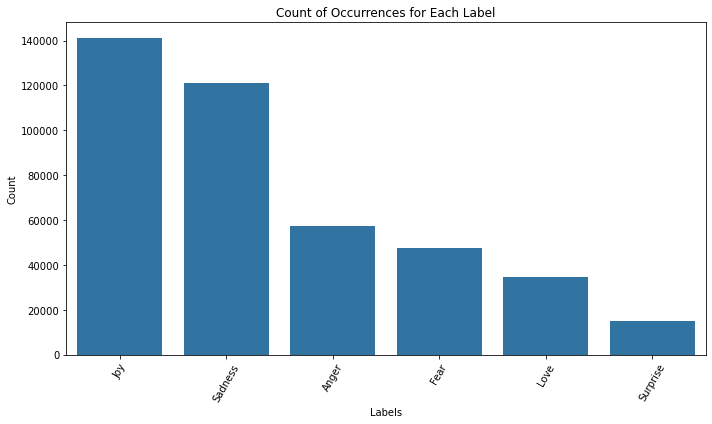

In [3]:
#Renaming Labels to corresponding emotions for graph production. 
df['label'] = df['label'].replace(0,'Sadness')
df['label'] = df['label'].replace(1,'Joy')
df['label'] = df['label'].replace(2,'Love')
df['label'] = df['label'].replace(3,'Anger')
df['label'] = df['label'].replace(4,'Fear')
df['label'] = df['label'].replace(5,'Surprise')

#Plotting the occurrance of each new label.
#Getting the count of each label.
label_counts = df['label'].value_counts()
#Extract the labels sorted by count.
ordered_labels = label_counts.index.tolist()
plt.figure(figsize=(10, 6))  
#Adjust the figure size if needed.
sns.countplot(data=df, x='label', order=ordered_labels)
#Set labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Occurrences for Each Label')
plt.xticks(rotation=60)  
#Rotate x-axis labels for better readability if needed.
plt.tight_layout() 
#Adjust layout to prevent labels from being cut off.
plt.show()

In [4]:
#Reversing the labelling edit.
df['label'] = df['label'].replace('Sadness',0)
df['label'] = df['label'].replace('Joy',1)
df['label'] = df['label'].replace('Love',2)
df['label'] = df['label'].replace('Anger',3)
df['label'] = df['label'].replace('Fear',4)
df['label'] = df['label'].replace('Surprise',5)

C:\Users\Finlay\AppData\Local\Temp/ipykernel_21288/2180150000.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace('Surprise',5)


In [5]:
#Removal of stopwords.
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [6]:
#Train-test split of data with a fixed randomstate. 
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

#Checking data type, as it must be array for later processing.
print(type(X_test))
check = np.expand_dims(X_test, axis=0)
print(type(check))

X_train shape: (333447,)
X_test shape: (83362,)
y_train shape: (333447,)
y_test shape: (83362,)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [7]:
#Create multiple training sets, each with one label missing to generate secondary labels.
#Function to create consistent datasets so no variation in test sets accross all label combinations. 
#Tokenize the text data.
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [8]:
#Padding
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')

In [9]:
#Creating an index list of each particular label.
index_list0 = [i for i, value in enumerate(y_train) if value == 0]
index_list1 = [i for i, value in enumerate(y_train) if value == 1]
index_list2 = [i for i, value in enumerate(y_train) if value == 2]
index_list3 = [i for i, value in enumerate(y_train) if value == 3]
index_list4 = [i for i, value in enumerate(y_train) if value == 4]
index_list5 = [i for i, value in enumerate(y_train) if value == 5]

In [10]:
#Creating variables for each removed index list.
#This takes a fairly long time.
X_train_padded0 = [value for i, value in enumerate(X_train_padded) if i not in index_list0]
X_train_padded1 = [value for i, value in enumerate(X_train_padded) if i not in index_list1]
X_train_padded2 = [value for i, value in enumerate(X_train_padded) if i not in index_list2]
X_train_padded3 = [value for i, value in enumerate(X_train_padded) if i not in index_list3]
X_train_padded4 = [value for i, value in enumerate(X_train_padded) if i not in index_list4]
X_train_padded5 = [value for i, value in enumerate(X_train_padded) if i not in index_list5]
#Converting to array.
X_train_padded0 = tf.stack(X_train_padded0)
X_train_padded1 = tf.stack(X_train_padded1)
X_train_padded2 = tf.stack(X_train_padded2)
X_train_padded3 = tf.stack(X_train_padded3)
X_train_padded4 = tf.stack(X_train_padded4)
X_train_padded5 = tf.stack(X_train_padded5)

In [11]:
#Creating the corresponding y values for each label.
y_train0 =  y_train[y_train != 0]
y_train1 =  y_train[y_train != 1]
y_train2 =  y_train[y_train != 2]
y_train3 =  y_train[y_train != 3]
y_train4 =  y_train[y_train != 4]
y_train5 =  y_train[y_train != 5]

In [14]:
#Convolutional Neural Network model function. 
def nlpmodel(X_tr, y_tr, X_te, y_te):
    #Construction of the model itself
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_size=(100,))
    #Very marginally better results using more filters and with a larger kernel size.
    #But, using 64 filters and kernel size 3 allows a faster model time without sacrificing much accuracy.
    #Relu activation is fast and standard for many nlp models.
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(units=64, activation='relu'))
    #Softmax makes the output easier to interpret as a vector of probabilities for each emotion label.
    cnn_model.add(Dense(units=6, activation='softmax'))
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    #Stops epochs early when val loss does not improve over 3 epochs.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history_cnn = cnn_model.fit(X_tr, y_tr, epochs=50, 
                                 validation_data=(X_te, y_te),
                                 callbacks=[early_stopping])
    #Evaluating the model.
    evaluation_result = cnn_model.evaluate(X_te, y_te)
    print("Test Loss:", evaluation_result[0])
    print("Test Accuracy:", evaluation_result[1])
    #y_pred and y_pred_score are the best predicted labels and highest label probabilities respectively. 
    #These are what the function returns for label evalutation. 
    y_pred = np.argmax(cnn_model.predict(X_te), axis=1)
    y_pred_score = np.amax(cnn_model.predict(X_te), axis=1)
    target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']  
    report = classification_report(y_te, y_pred, target_names=target_names)
    print(report)
    #Confusion matrix plotting.
    conf_mat = confusion_matrix(y_te, y_pred)
    emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    #Loss plotting.
    train_loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    train_acc = history_cnn.history['accuracy']
    val_acc = history_cnn.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    #Training vs Validation Loss.
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #Training vs Validation Accuracy.
    plt.figure()
    plt.plot(epochs, train_acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    #All predicted values.
    y_score = cnn_model.predict(X_te)
    #ROC Curve plotting
    y_test_bin = label_binarize(y_te, classes=[0, 1, 2, 3, 4, 5])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 6  
    class_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #Plot ROC curve for each class with distinct colours
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return y_pred, y_pred_score

In [15]:
#List of models for each removed emotion.
testlists = []
testlistsprobs = []



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

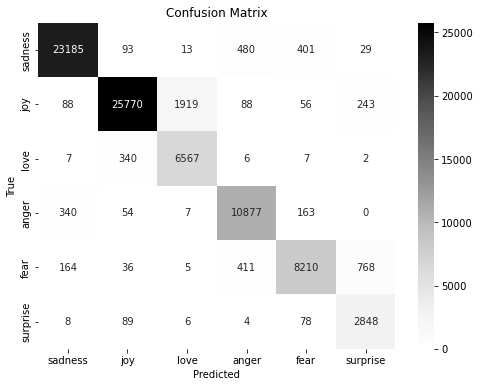

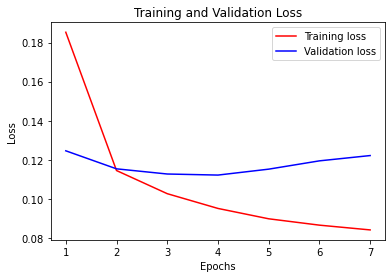

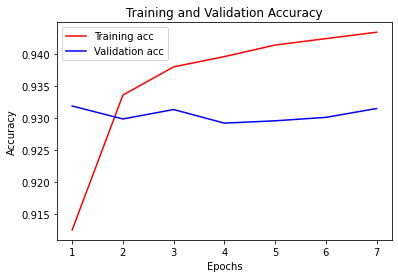

2606/2606 [==============================] - 3s 1ms/step


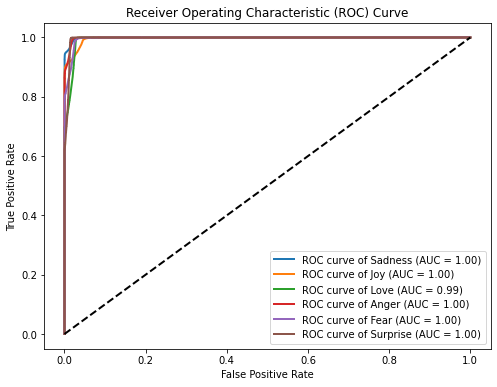

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.00      0.00      0.00     24201
         Joy       0.57      0.99      0.72     28164
        Love       0.81      0.72      0.76      6929
       Anger       0.80      0.94      0.86     11441
        Fear       0.82      0.90      0.86      9594
    Surprise       0.69      0.90      0.78      3033

    accuracy                           0.66     83362
   macro avg       0.62      0.74      0.67     83362
weighted avg       0.49      0.66      0.55     83362



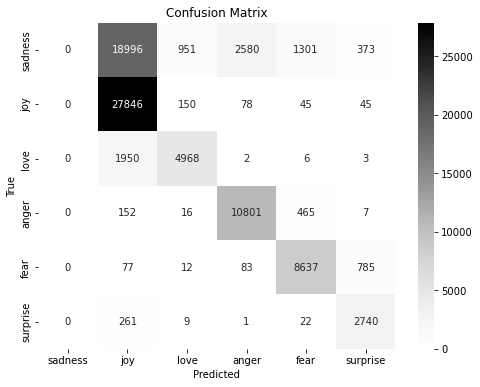

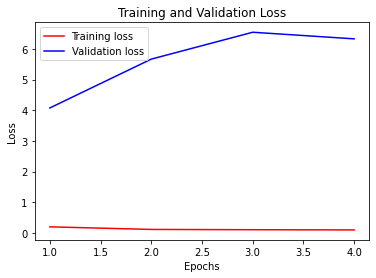

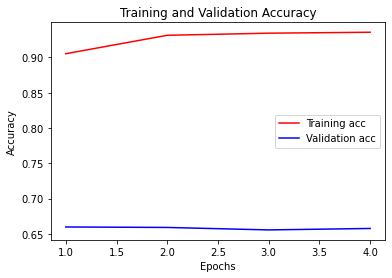

2606/2606 [==============================] - 3s 1ms/step


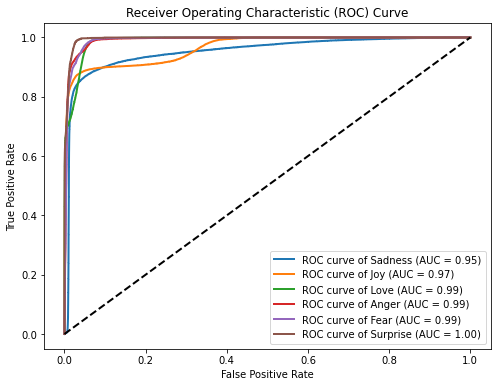

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.53      0.99      0.69     24201
         Joy       0.00      0.00      0.00     28164
        Love       0.59      0.99      0.74      6929
       Anger       0.78      0.94      0.85     11441
        Fear       0.90      0.82      0.86      9594
    Surprise       0.67      0.94      0.78      3033

    accuracy                           0.63     83362
   macro avg       0.58      0.78      0.65     83362
weighted avg       0.44      0.63      0.51     83362



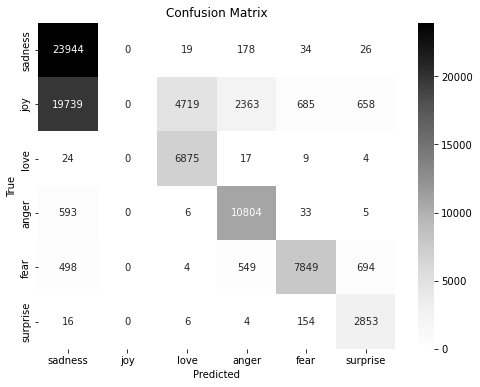

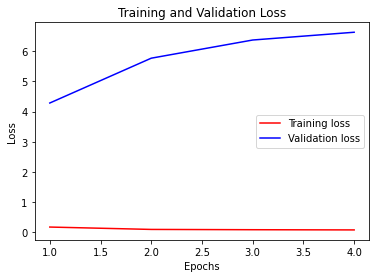

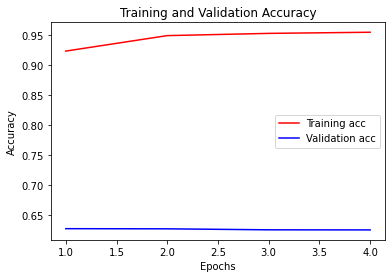

2606/2606 [==============================] - 3s 1ms/step


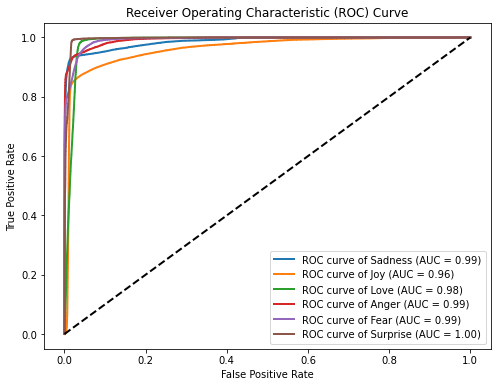

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.90      0.98      0.94     24201
         Joy       0.85      0.98      0.91     28164
        Love       0.00      0.00      0.00      6929
       Anger       0.90      0.94      0.92     11441
        Fear       0.88      0.88      0.88      9594
    Surprise       0.77      0.85      0.81      3033

    accuracy                           0.87     83362
   macro avg       0.72      0.77      0.74     83362
weighted avg       0.80      0.87      0.84     83362



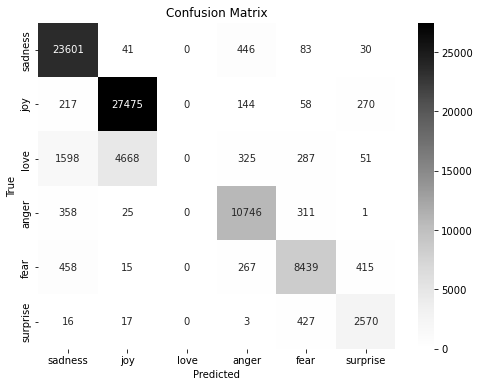

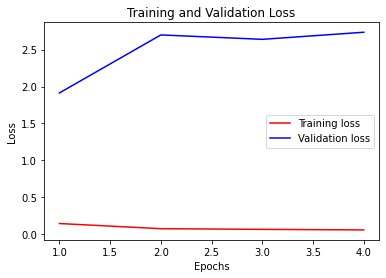

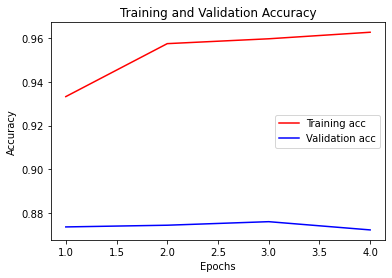

2606/2606 [==============================] - 3s 1ms/step


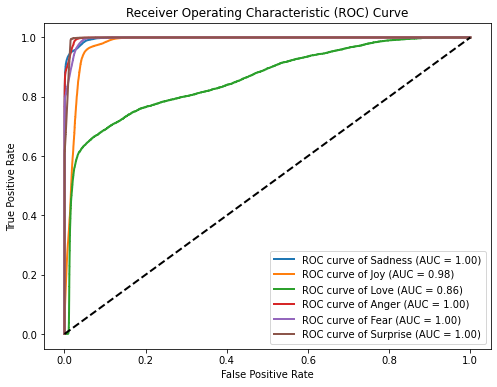

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_4 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.86      0.98      0.92     24201
         Joy       0.78      0.91      0.84     28164
        Love       0.74      0.98      0.85      6929
       Anger       0.00      0.00      0.00     11441
        Fear       0.82      0.95      0.88      9594
    Surprise       0.87      0.68      0.76      3033

    accuracy                           0.81     83362
   macro avg       0.68      0.75      0.71     83362
weighted avg       0.70      0.81      0.75     83362



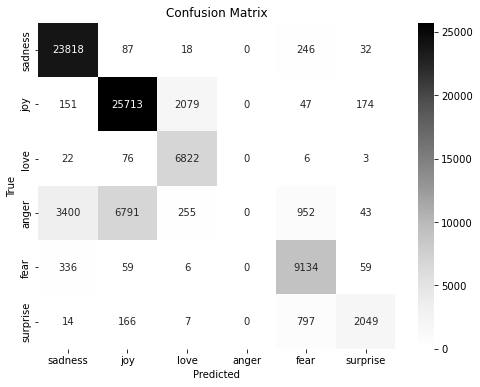

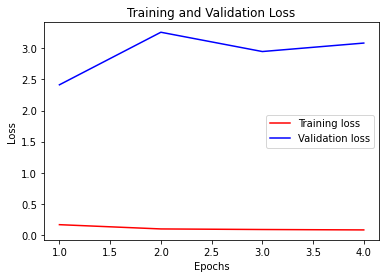

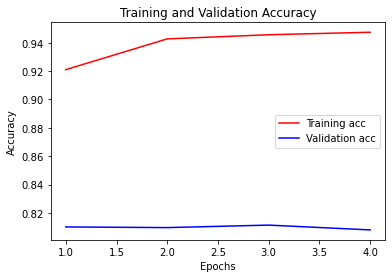

2606/2606 [==============================] - 3s 991us/step


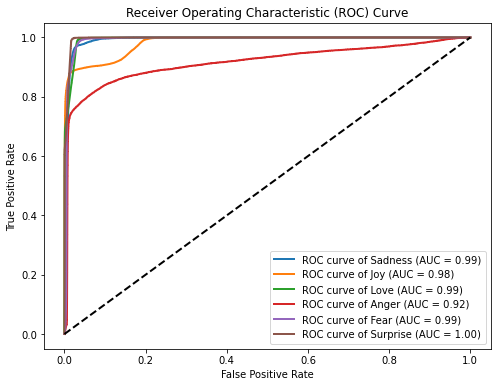

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_5 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_5 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.84      0.99      0.91     24201
         Joy       0.83      0.98      0.90     28164
        Love       0.95      0.70      0.81      6929
       Anger       0.89      0.94      0.92     11441
        Fear       0.00      0.00      0.00      9594
    Surprise       0.65      0.98      0.78      3033

    accuracy                           0.84     83362
   macro avg       0.69      0.77      0.72     83362
weighted avg       0.75      0.84      0.79     83362



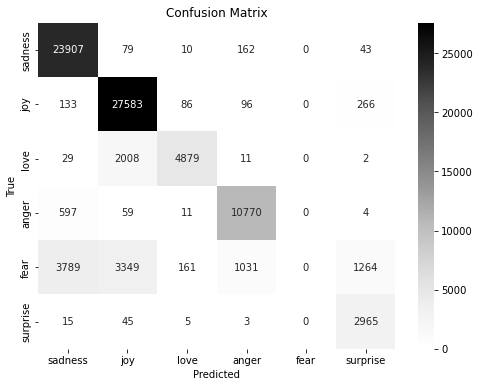

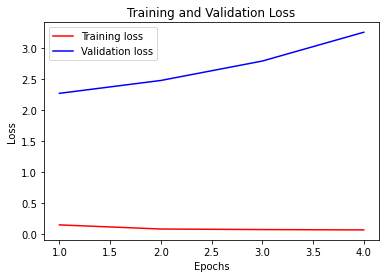

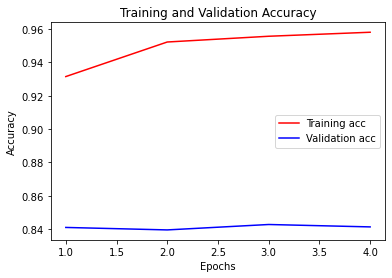

2606/2606 [==============================] - 3s 1ms/step


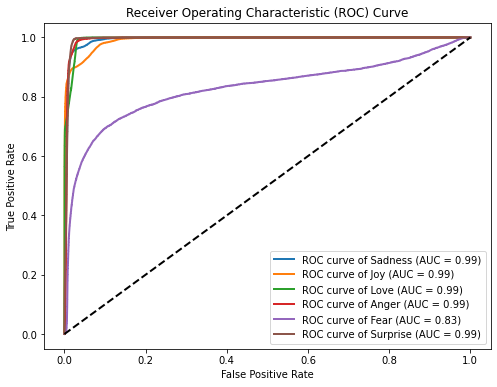

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_6 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 6)                 390       
                                                                 
Total params: 807686 (3.08 MB)
Trainable params: 807686 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Sadness       0.94      0.98      0.96     24201
         Joy       0.89      0.98      0.93     28164
        Love       0.90      0.76      0.82      6929
       Anger       0.97      0.90      0.93     11441
        Fear       0.86      0.94      0.90      9594
    Surprise       0.00      0.00      0.00      3033

    accuracy                           0.91     83362
   macro avg       0.76      0.76      0.76     83362
weighted avg       0.88      0.91      0.89     83362



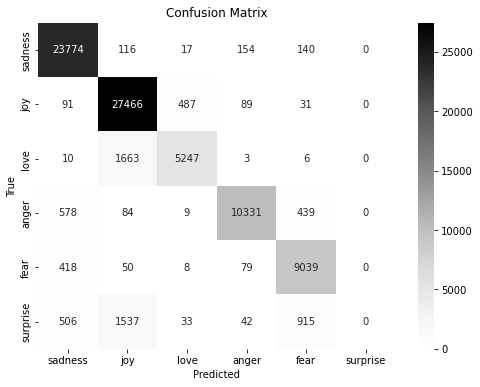

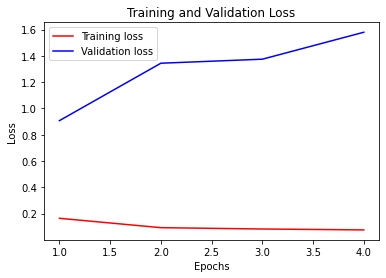

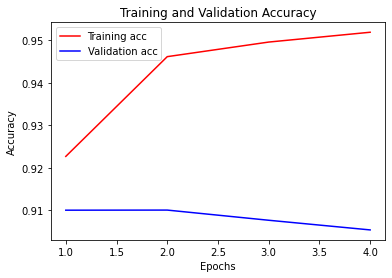

2606/2606 [==============================] - 3s 1ms/step


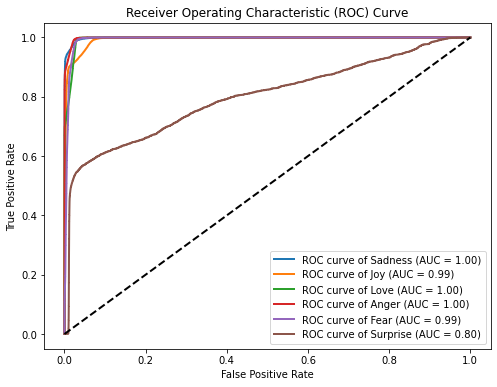

In [16]:
#Running the function for all labels, and for each dataset with training labels removed.
#Appending the y_pred and y_pred_score to the testlists and testlistsprobs lists.
original = nlpmodel(X_train_padded, y_train, X_test_padded, y_test)
testlists.append(original[0])
testlistsprobs.append(original[1])
no0 = nlpmodel(X_train_padded0, y_train0, X_test_padded, y_test)
testlists.append(no0[0])
testlistsprobs.append(no0[1])
no1 = nlpmodel(X_train_padded1, y_train1, X_test_padded, y_test)
testlists.append(no1[0])
testlistsprobs.append(no1[1])
no2 = nlpmodel(X_train_padded2, y_train2, X_test_padded, y_test)
testlists.append(no2[0])
testlistsprobs.append(no2[1])
no3 = nlpmodel(X_train_padded3, y_train3, X_test_padded, y_test)
testlists.append(no3[0])
testlistsprobs.append(no3[1])
no4 = nlpmodel(X_train_padded4, y_train4, X_test_padded, y_test)
testlists.append(no4[0])
testlistsprobs.append(no4[1])
no5 = nlpmodel(X_train_padded5, y_train5, X_test_padded, y_test)
testlists.append(no5[0])
testlistsprobs.append(no5[1])

In [18]:
print(testlists)
print(testlistsprobs)
#Dataframe A for the labels, Dataframe B for the probabilities.
#Separate dataframes as not all the data needs to be included in the final dataframe, and the separate dataframes can be iterated over.
df_A = pd.DataFrame(list(map(np.ravel, testlists))).T
print(df_A)
df_B = pd.DataFrame(list(map(np.ravel, testlistsprobs))).T
print(df_B)

[array([0, 0, 3, ..., 1, 3, 0], dtype=int64), array([1, 2, 3, ..., 1, 3, 1], dtype=int64), array([0, 0, 3, ..., 0, 3, 0], dtype=int64), array([0, 0, 3, ..., 1, 3, 0], dtype=int64), array([0, 0, 1, ..., 1, 1, 0], dtype=int64), array([0, 0, 3, ..., 1, 3, 0], dtype=int64), array([0, 0, 3, ..., 1, 3, 0], dtype=int64)]
[array([0.9999765 , 0.9999871 , 0.9986401 , ..., 0.99999857, 0.99977237,
       0.9999144 ], dtype=float32), array([0.9101161 , 0.55563   , 0.9863571 , ..., 0.99995816, 0.9889922 ,
       0.6090526 ], dtype=float32), array([0.99995387, 0.99994946, 0.9655287 , ..., 0.55945927, 0.99873525,
       0.99996436], dtype=float32), array([0.99995875, 0.9996244 , 0.9855542 , ..., 0.9996    , 0.9976012 ,
       0.99996185], dtype=float32), array([0.9999416 , 0.9999511 , 0.86561275, ..., 0.9998802 , 0.9773064 ,
       0.9999536 ], dtype=float32), array([0.9997954 , 0.99959403, 0.99732804, ..., 0.99998605, 0.99677914,
       0.999485  ], dtype=float32), array([0.9996923 , 0.99938023, 0.87

In [19]:
#For each row in dataframe A:
#Step 1 - identify which columns value is not equal to column "0" and take the value
#Step 2 - find the corresponding value in dataframe B
#Step 3 - generate new dataframe with the dataframe A and B's column "0" and a column for the values of step 1 and step 2
#Empty list to recieve output
result_data = []
#For each row in DataFrame A
for index, row in df_A.iterrows():
    #Find the indices where values in A differ from A_0
    diff_indices = [i for i, value in enumerate(row) if value != row[0]]
    #Collect the values of A_0 and corresponding values from B.
    #Only collecting the first index per row where there is a difference, else multiple datapoints will emerge from the same input.
    for i in diff_indices[:1]:
        result_data.append({
            'A_0': row[0],
            'B_0': df_B.iloc[index, 0],
            'A_B_combined': row[i],
            'B_B_combined': df_B.iloc[index, i]
        })
# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_data)
result_df = result_df.dropna()
# Display the resulting DataFrame
print(result_df)

       A_0       B_0  A_B_combined  B_B_combined
0        0  0.999977             1      0.910116
1        0  0.999987             2      0.555630
2        3  0.998640             1      0.865613
3        0  0.999977             1      0.606924
4        1  1.000000             0      0.902912
...    ...       ...           ...           ...
83357    0  0.999996             1      0.999373
83358    1  0.999958             2      0.450421
83359    1  0.999999             0      0.559459
83360    3  0.999772             1      0.977306
83361    0  0.999914             1      0.609053

[83362 rows x 4 columns]


In [20]:
#Renaming the columns of the dataframe to easily interpretable strings.
result_df = result_df.rename(columns={"A_0": "Current_label", "B_0": "Current_prob", "A_B_combined": "Alt_label", "B_B_combined": "Alt_prob"})
print(result_df)
#Saving the output as a .csv as a backup.
result_df.to_csv("endoutput.csv")

       Current_label  Current_prob  Alt_label  Alt_prob
0                  0      0.999977          1  0.910116
1                  0      0.999987          2  0.555630
2                  3      0.998640          1  0.865613
3                  0      0.999977          1  0.606924
4                  1      1.000000          0  0.902912
...              ...           ...        ...       ...
83357              0      0.999996          1  0.999373
83358              1      0.999958          2  0.450421
83359              1      0.999999          0  0.559459
83360              3      0.999772          1  0.977306
83361              0      0.999914          1  0.609053

[83362 rows x 4 columns]


In [21]:
#Generation of combination labels.
#Each datapoint has a label, and an alternative label with an associated probability given that the original label was unavailable.
#Many of these labels are given with high probabilities (Some even above the 99.9% threshold), demonstrating that some text has ambiguous, or multiple present emotional sentiments.
#So, all combinations of current and alternate labels will be generated as new labels, and where the alternative label probability is high enough, the label will be replaced by a combination label.
#Empty dictionary for label mapping.
combination_label_mapping = {}
label = 6
#Generate all possible combinations of two numbers between 0 and 5 without repetitions.
for i in range(6):
    for j in range(i, 6):
        #Avoiding repeat combinations as the sentiment is still the same.
        if i != j:  
            combination_label_mapping[(i, j)] = label
            # Also map (j, i) to the same label.
            combination_label_mapping[(j, i)] = label
            label += 1
print(combination_label_mapping)
#Iterate through the dataframe and assign new labels based on the combination of current and alt labels
new_labels = []
for index, row in result_df.iterrows():
    #Setting the probability to any value, this can be altered to analyse the impact on the dataset. For the initial main processing it will be set at 0.7, reflecting a 70% probability for the alternative label.
    #Though, for observation, this can be set as high as 0.999 to view which labels are almost certainly multiple sentiments.
    if row['Alt_prob'] > 0.7:
        new_label = combination_label_mapping[(row['Current_label'], row['Alt_label'])]
        new_labels.append(new_label)
    else:
        new_labels.append(row['Current_label'])
new_labels = [int(x) for x in new_labels]
#Print the new labels
#print(new_labels)

{(0, 1): 6, (1, 0): 6, (0, 2): 7, (2, 0): 7, (0, 3): 8, (3, 0): 8, (0, 4): 9, (4, 0): 9, (0, 5): 10, (5, 0): 10, (1, 2): 11, (2, 1): 11, (1, 3): 12, (3, 1): 12, (1, 4): 13, (4, 1): 13, (1, 5): 14, (5, 1): 14, (2, 3): 15, (3, 2): 15, (2, 4): 16, (4, 2): 16, (2, 5): 17, (5, 2): 17, (3, 4): 18, (4, 3): 18, (3, 5): 19, (5, 3): 19, (4, 5): 20, (5, 4): 20}


In [22]:
#New dataframe of the new labels for each point. 
new_labels_df = pd.DataFrame(np.array([new_labels]).T)
#Renaming the column as label.
new_labels_df.columns = ["label"]
print(new_labels_df)
#new_labels_df.to_csv("newlabels.csv")

       label
0          6
1          0
2         12
3          0
4          6
...      ...
83357      6
83358      1
83359      1
83360     12
83361      0

[83362 rows x 1 columns]


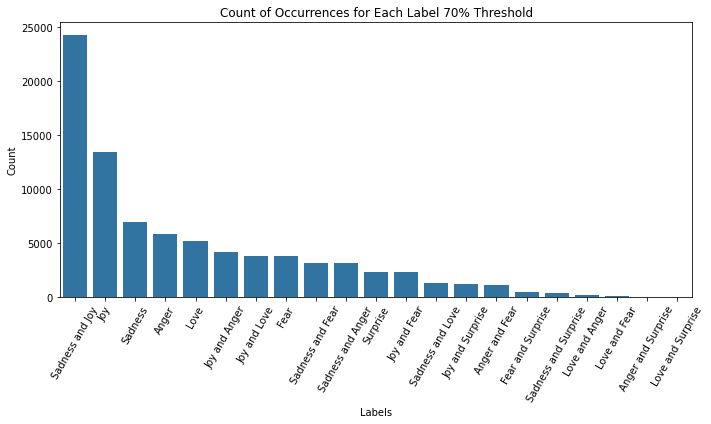

In [23]:
#Renaming Labels to corresponding emotions for graph production. 
new_labels_df["label"] = new_labels_df["label"].replace(0,'Sadness')
new_labels_df["label"] = new_labels_df["label"].replace(1,'Joy')
new_labels_df["label"] = new_labels_df["label"].replace(2,'Love')
new_labels_df["label"] = new_labels_df["label"].replace(3,'Anger')
new_labels_df["label"] = new_labels_df["label"].replace(4,'Fear')
new_labels_df["label"] = new_labels_df["label"].replace(5,'Surprise')
new_labels_df["label"] = new_labels_df["label"].replace(6,'Sadness and Joy')
new_labels_df["label"] = new_labels_df["label"].replace(7,'Sadness and Love')
new_labels_df["label"] = new_labels_df["label"].replace(8,'Sadness and Anger')
new_labels_df["label"] = new_labels_df["label"].replace(9,'Sadness and Fear')
new_labels_df["label"] = new_labels_df["label"].replace(10,'Sadness and Surprise')
new_labels_df["label"] = new_labels_df["label"].replace(11,'Joy and Love')
new_labels_df["label"] = new_labels_df["label"].replace(12,'Joy and Anger')
new_labels_df["label"] = new_labels_df["label"].replace(13,'Joy and Fear')
new_labels_df["label"] = new_labels_df["label"].replace(14,'Joy and Surprise')
new_labels_df["label"] = new_labels_df["label"].replace(15,'Love and Anger')
new_labels_df["label"] = new_labels_df["label"].replace(16,'Love and Fear')
new_labels_df["label"] = new_labels_df["label"].replace(17,'Love and Surprise')
new_labels_df["label"] = new_labels_df["label"].replace(18,'Anger and Fear')
new_labels_df["label"] = new_labels_df["label"].replace(19,'Anger and Surprise')
new_labels_df["label"] = new_labels_df["label"].replace(20,'Fear and Surprise')
#Plotting the occurrance of each new label.
#Getting the count of each label.
label_counts = new_labels_df['label'].value_counts()
#Extract the labels sorted by count.
ordered_labels = label_counts.index.tolist()
plt.figure(figsize=(10, 6))  
#Adjust the figure size if needed.
sns.countplot(data=new_labels_df, x='label', order=ordered_labels)
#Set labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Occurrences for Each Label 70% Threshold')
plt.xticks(rotation=60)  
#Rotate x-axis labels for better readability if needed.
plt.tight_layout() 
#Adjust layout to prevent labels from being cut off.
plt.show()

In [24]:
#Undoing the label renaming.
new_labels_df["label"] = new_labels_df["label"].replace('Sadness',0)
new_labels_df["label"] = new_labels_df["label"].replace('Joy',1)
new_labels_df["label"] = new_labels_df["label"].replace('Love',2)
new_labels_df["label"] = new_labels_df["label"].replace('Anger',3)
new_labels_df["label"] = new_labels_df["label"].replace('Fear',4)
new_labels_df["label"] = new_labels_df["label"].replace('Surprise',5)
new_labels_df["label"] = new_labels_df["label"].replace('Sadness and Joy',6)
new_labels_df["label"] = new_labels_df["label"].replace('Sadness and Love',7)
new_labels_df["label"] = new_labels_df["label"].replace('Sadness and Anger',8)
new_labels_df["label"] = new_labels_df["label"].replace('Sadness and Fear',9)
new_labels_df["label"] = new_labels_df["label"].replace('Sadness and Surprise',10)
new_labels_df["label"] = new_labels_df["label"].replace('Joy and Love',11)
new_labels_df["label"] = new_labels_df["label"].replace('Joy and Anger',12)
new_labels_df["label"] = new_labels_df["label"].replace('Joy and Fear',13)
new_labels_df["label"] = new_labels_df["label"].replace('Joy and Surprise',14)
new_labels_df["label"] = new_labels_df["label"].replace('Love and Anger',15)
new_labels_df["label"] = new_labels_df["label"].replace('Love and Fear',16)
new_labels_df["label"] = new_labels_df["label"].replace('Love and Surprise',17)
new_labels_df["label"] = new_labels_df["label"].replace('Anger and Fear',18)
new_labels_df["label"] = new_labels_df["label"].replace('Anger and Surprise',19)
new_labels_df["label"] = new_labels_df["label"].replace('Fear and Surprise',20)

C:\Users\Finlay\AppData\Local\Temp/ipykernel_21288/1359713648.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_labels_df["label"] = new_labels_df["label"].replace('Fear and Surprise',20)


In [25]:
#Creating new dataframe from old test text.
print(type(new_labels_df))
print(type(X_test))
new_xtest = pd.DataFrame(X_test)
new_xtest = new_xtest.reset_index(drop=True)
frames = [new_labels_df, new_xtest]
result = pd.concat(frames, axis = 1, join = "inner")
display(result)

#result.to_csv("label70prob.csv")

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


,label,text
0,6,id say maybe made feel foolish would reeeeeeal...
1,0,joined lds church admit feeling somewhat asham...
2,12,must admit didnt feel like hugging angry disgu...
3,0,hate still feel nerve damaged badly enough oft...
4,6,im actually feeling little smug
...,...,...
83357,6,need know pain feel vain better brighter day f...
83358,1,feel type work really suits well
83359,1,finished taking exams need relax said suddenly...
83360,12,swear fireworks outside cool breeze siren song...


In [26]:
#Train-test-split, tokenisation, and padding of the new labelled data.
X = result['text']
y = result['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
#Checking data type, as it must be array for later processing.
print(type(X_test))
check = np.expand_dims(X_test, axis=0)
print(type(check))
#Tokenize the text data.
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
#Padding
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')

X_train shape: (66689,)
X_test shape: (16673,)
y_train shape: (66689,)
y_test shape: (16673,)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [27]:
def nlpmodel_newlabel(X_tr, y_tr, X_te, y_te):
    #Construction of the model itself
    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_size=(100,))
    #Very marginally better results using more filters and with a larger kernel size (difference in accuracy of 0.9337 and 0.9335).
    #So, using 64 filters and kernel size 3 allows a faster model time without sacrificing much accuracy.
    #Relu activation is fast and standard for many nlp models.
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(units=64, activation='relu'))
    #Softmax makes the output easier to interpret as a vector of probabilities for each emotion label.
    cnn_model.add(Dense(units=21, activation='softmax'))
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    #Stops epochs early when val loss does not improve over 3 epochs.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history_cnn = cnn_model.fit(X_tr, y_tr, epochs=50, 
                                 validation_data=(X_te, y_te),
                                 callbacks=[early_stopping])
    #Evaluating the model.
    evaluation_result = cnn_model.evaluate(X_te, y_te)
    print("Test Loss:", evaluation_result[0])
    print("Test Accuracy:", evaluation_result[1])
    #y_pred and y_pred_score are the best predicted labels and highest label probabilities respectively. 
    #These are what the function returns for label evalutation. 
    y_pred = np.argmax(cnn_model.predict(X_te), axis=1)
    y_pred_score = np.amax(cnn_model.predict(X_te), axis=1)
    target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise', 'Sadness and Joy','Sadness and Love','Sadness and Anger','Sadness and Fear','Sadness and Surprise','Joy and Love','Joy and Anger','Joy and Fear','Joy and Surprise','Love and Anger','Love and Fear','Love and Surprise','Anger and Fear','Anger and Surprise','Fear and Surprise'] 
    report = classification_report(y_te, y_pred, target_names=target_names)
    print(report)
    #Confusion matrix plotting.
    conf_mat = confusion_matrix(y_te, y_pred)
    emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise', 'Sadness and Joy','Sadness and Love','Sadness and Anger','Sadness and Fear','Sadness and Surprise','Joy and Love','Joy and Anger','Joy and Fear','Joy and Surprise','Love and Anger','Love and Fear','Love and Surprise','Anger and Fear','Anger and Surprise','Fear and Surprise']
    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    #Loss plotting.
    train_loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    train_acc = history_cnn.history['accuracy']
    val_acc = history_cnn.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    #Training vs Validation Loss.
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #Training vs Validation Accuracy.
    plt.figure()
    plt.plot(epochs, train_acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    #All predicted values.
    y_score = cnn_model.predict(X_te)
    #ROC Curve plotting
    y_test_bin = label_binarize(y_te, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 21
    class_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise', 'Sadness and Joy','Sadness and Love','Sadness and Anger','Sadness and Fear','Sadness and Surprise','Joy and Love','Joy and Anger','Joy and Fear','Joy and Surprise','Love and Anger','Love and Fear','Love and Surprise','Anger and Fear','Anger and Surprise','Fear and Surprise']
    plt.figure(figsize=(16, 12))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #Plot ROC curve for each class with distinct colours
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return y_pred, y_pred_score

In [13]:
#print(type(X_test_padded))
#X_test_single = X_test_padded[1]
#X_test_single = np.expand_dims(X_test_single, axis=0)
#class_probabilities = cnn_model.predict(X_test_single)
#
#predicted_class = np.argmax(class_probabilities)
#predicted_class_value = np.amax(class_probabilities)
#print(X_test_single)
#print("Predicted class label:", predicted_class)
#print("Predicted class probability:", predicted_class_value)
#print("Class probabilities:", class_probabilities)

<class 'numpy.ndarray'>


NameError: name 'cnn_model' is not defined

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 16)           800000    
                                                                 
 conv1d_7 (Conv1D)           (None, 98, 64)            3136      
                                                                 
 global_max_pooling1d_7 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 21)                1365      
                                                                 
Total params: 808661 (3.08 MB)
Trainable params: 808661 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Finlay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

             Sadness       0.76      0.73      0.74      1428
                 Joy       0.84      0.85      0.84      2713
                Love       0.82      0.72      0.77      1013
               Anger       0.78      0.70      0.74      1162
                Fear       0.76      0.62      0.68       733
            Surprise       0.81      0.75      0.78       478
     Sadness and Joy       0.87      0.87      0.87      4841
    Sadness and Love       0.70      0.77      0.73       256
   Sadness and Anger       0.79      0.79      0.79       645
    Sadness and Fear       0.76      0.89      0.82       627
Sadness and Surprise       0.59      0.72      0.65        71
        Joy and Love       0.68      0.73      0.70       778
       Joy and Anger       0.68      0.84      0.75       817
        Joy and Fear       0.78      0.82      0.80       469
    Joy and Surprise       0.60      0.86      0.70       236
      L

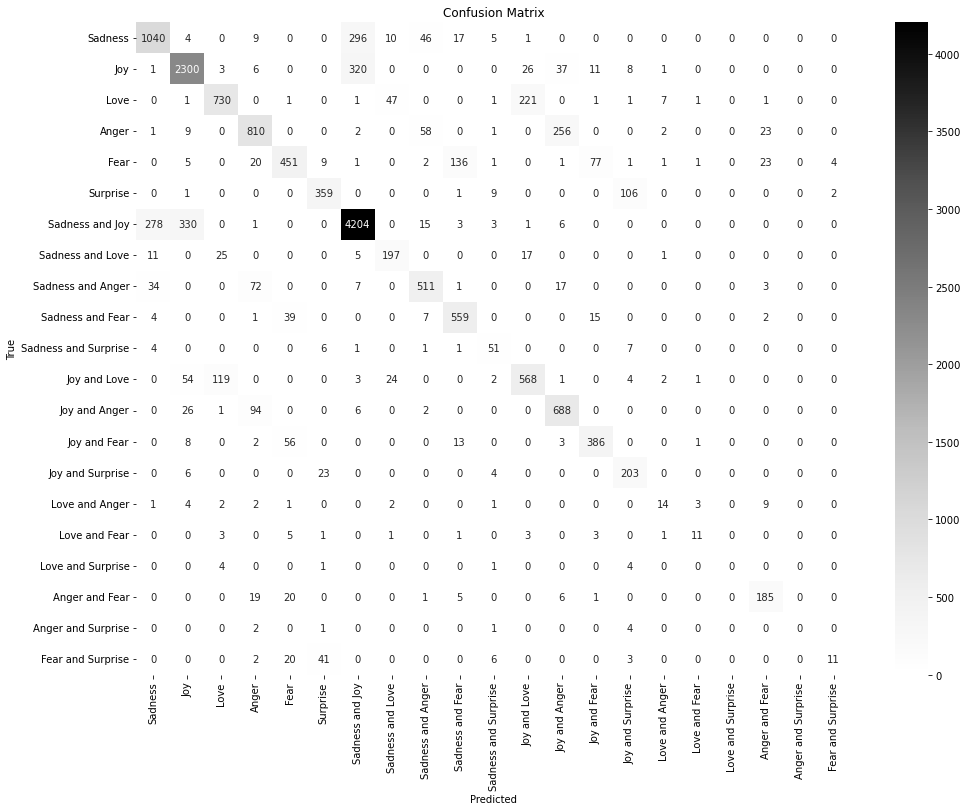

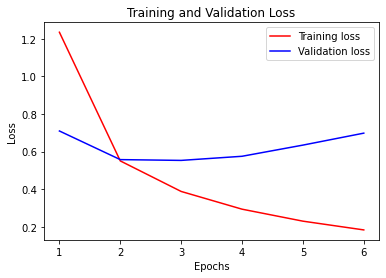

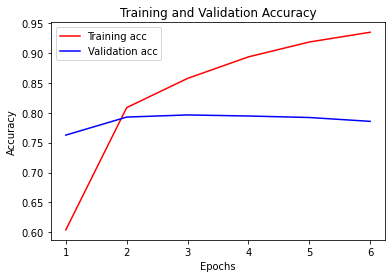

522/522 [==============================] - 1s 1ms/step


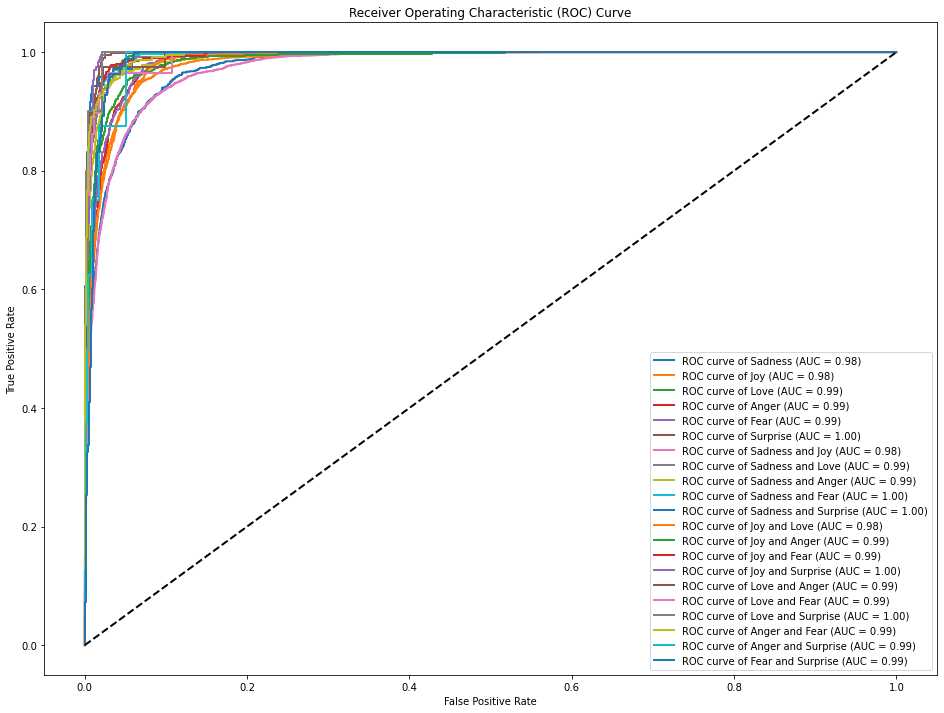

In [28]:
#Final model with the new labels.
new_label_model = nlpmodel_newlabel(X_train_padded, y_train, X_test_padded, y_test)